## CLEFIA CPA Attack

```
Conduct Correlation Power Analysis attacks at the first, second and last rounds of CLEFIA-128 encryption. 

Authors: Arjun Menon V (ee18b104), Akilesh Kannan (ee18b122)
```

Assignment 2, Secure Processor Microarchitecture

August 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

In [2]:
# Load input and power trace
textInp = np.load("../EE18B104_EE18B122/trace_002/textin_array.npy", "r")
powerTrace = np.load("../EE18B104_EE18B122/trace_002/trace_array.npy", "r")
cipherText = np.load("../EE18B104_EE18B122/trace_002/textout_array.npy", "r")
#
s0Arr = np.load("../data/s0.npy", "r")
s1Arr = np.load("../data/s1.npy", "r")
#
tf00Arr = np.load("../data/tf00.npy", "r")
tf01Arr = np.load("../data/tf01.npy", "r")
tf02Arr = np.load("../data/tf02.npy", "r")
tf03Arr = np.load("../data/tf03.npy", "r")
#
tf10Arr = np.load("../data/tf10.npy", "r")
tf11Arr = np.load("../data/tf11.npy", "r")
tf12Arr = np.load("../data/tf12.npy", "r")
tf13Arr = np.load("../data/tf13.npy", "r")


print(textInp.shape)
print(powerTrace.shape)

(12000, 16)
(12000, 18000)


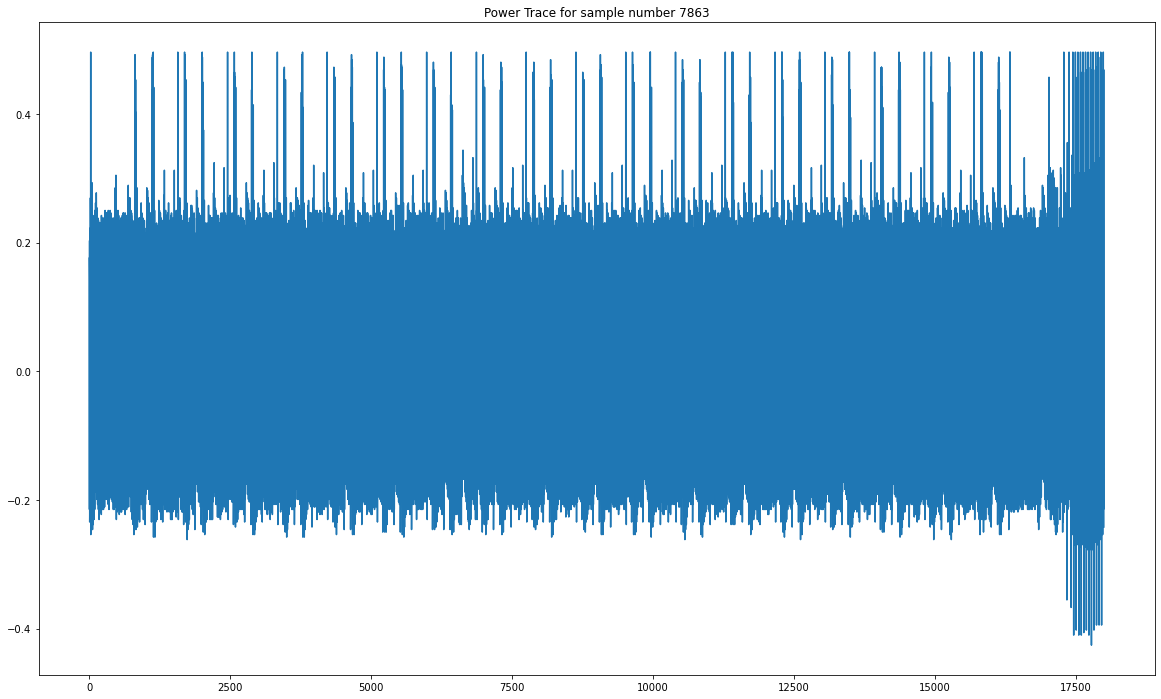

In [3]:
# Visualize Power Trace:
plt.figure(figsize=(20, 12))
idx = np.random.randint(0, powerTrace.shape[0])
plt.plot(powerTrace[idx])
plt.title("Power Trace for sample number "+ str(idx))
plt.show()


### Where do you take the Intermediate Result?

At this point, we have three choices on the location of the intermediate result:

- Output of the SBox opertion, in the GFN4 network
- Output of the T table, in the GFN4 network
- Output of the F0/1 operation in the GFN4 network

The output of each SBox is an 8-bit word, and hence we can perform key search with $2^8$ guesses for each of the 16 Bytes of the Key. On the contrary, the output of the F functions are 32-bits wide and the search space involves $2^{32}$ possibilities for each of the 4 Words of the key. 

However, if the implementation uses a look-up table for the entire F function, without evaluating the intermediate SBox result, the former attack scheme will not work as there won't be any correlation between the intermediate result and the power trace. Hence this is a weaker attack, despite having lower online complexity. 

**Approach:**

- Try the SBox attack first and see if correlations are got with sufficient confidence
- Repeat the attack using T table output as the intermediate result
- Validate the results against the PT-CT pair provided
- If the previous attack fails, try the F0/1 attack

### CPA at the SBox Output

**First Round of CLEFIA:**

PT = P0 | P1 | P2 | P3

T => P0 | P1 ^ WK0 | P2 | P3 ^ WK1

T => P0 ^ RK0 | P1 ^ WK0 | P2 ^ RK1 | P3 ^ WK1

T => S0(P0 ^ RK0) | P1 ^ WK0 | S1(P2 ^ RK1) | P3 ^ WK1  ---> Intermediate Result

P0 ^ RK0 sent to S0 function and P2 ^ RK1 to S1 bytewise, and the HW of the results are correlated against the power trace. To find WK's, the intermediate result used is $P_{2i + 1}$ ^ $WK_i$

**Last Round of CLEFIA:**

**Second Round of CLEFIA:**

In [11]:
def s0(inp):
    return s0Arr[inp]

def s1(inp):
    return s1Arr[inp]

def intermediate_0(pt_byte, key_byte):
    return s0(pt_byte ^ key_byte)

def intermediate_xor(pt_byte, wk_byte):
    return pt_byte ^ wk_byte

def intermediate_1(pt_byte, key_byte):
    return s1(pt_byte ^ key_byte)

# array holding HW of all 8-bit integers
HW = [ bin(n).count("1") for n in range(0, 256) ]

In [ ]:
guessTop5 = []
confScore = []
totTraces, numPoints = powerTrace.shape
alpha = 1.0
activeTraces = int(alpha * totTraces)
print(activeTraces)

attackType = "last"
startPoint = [800, 450, 1100, 15700, 16200, 16000]   # ['RK0', 'WK0/1', 'RK1', 'RK34', 'WK2/3', '']
endPoint = [1000, 700, 1300, 15900, 16800, 16200]

if (attackType == "first"):
    textArr = textInp
    offset = 0
elif (attackType == "last"):
    textArr = cipherText
    offset = 3

HWmatrix = np.zeros((totTraces, 256), dtype= np.uint8)
corrScore = np.zeros((16, 256, numPoints))

In [ ]:
# Infer RK0/RK34:
# region to track in the power trace for artefacts from the 1st round

'''
Bytes 0, 1, 2, 3:
StartPoint = 800
EndPoint = 1000 

Bytes 4-7, c-f:
StartPoint = 400
EndPoint = 800 

Bytes 8, 9, a, b:
StartPoint = 1100
EndPoint = 1400?
'''
keyGuess = []

for i in range(0, 4):
    for keyByte in tqdm(range(0, 256)):
        for traceNum in range(activeTraces):
            if (i % 2 == 0):
                interVal = intermediate_0(textArr[traceNum, i], keyByte)
            else:
                interVal = intermediate_1(textArr[traceNum, i], keyByte)
            HWmatrix[traceNum, keyByte] = HW[interVal]
       
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint[offset]:endPoint[offset]]
        corrScore[i, keyByte, startPoint[offset]:endPoint[offset]] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint[offset] - startPoint[offset])]
        
    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append((i, top5idx, maxScoreVec[top5idx]))
    keyGuess.append(top5idx[-1])
    print(guessTop5)
    print(corrScore[i].argmax(axis=1)[top5idx])
    print("Confidence Score: ", confScore, "Key Guesses: ", keyGuess)

if (attackType == "first"):
    fileName = "../data/keys/RK0"
else:
    fileName = "../data/keys/RK34"
np.save(fileName, keyGuess)

In [ ]:
# Infer WK0/1 or WK2/3:
# region to track in the power trace for artefacts from the 1st round
'''
Bytes 4-7, c-f:
StartPoint = 400
EndPoint = 800 
'''
keyGuess = []

for i in range(4, 8):
    for keyByte in tqdm(range(0, 256)):
        for traceNum in range(activeTraces):
            interVal = intermediate_xor(textArr[traceNum, i], keyByte)
            HWmatrix[traceNum, keyByte] = HW[interVal]
       
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint[offset+1]:endPoint[offset+1]]
        corrScore[i, keyByte, startPoint[offset+1]:endPoint[offset+1]] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint[offset+1] - startPoint[offset+1])]
        
    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-3])  # top-2 guesses are 1's complements of each other
    guessTop5.append((i, top5idx, maxScoreVec[top5idx]))
    keyGuess.append(top5idx[-1])
    print(guessTop5)
    print(corrScore[i].argmax(axis=1)[top5idx])
    print("Confidence Score: ", confScore, "Key Guesses: ", keyGuess)

if (attackType == "first"):
    fileName = "../data/keys/WK0_probable"
else:
    fileName = "../data/keys/WK2_probable"
np.save(fileName, keyGuess)

In [ ]:
# Infer RK1
# region to track in the power trace for artefacts from the 1st round
'''
Bytes 8, 9, a, b:
StartPoint = 1100
EndPoint = 1400 
'''
keyGuess = []

for i in range(8, 12):
    for keyByte in tqdm(range(0, 256)):
        for traceNum in range(activeTraces):
            if (i % 2 == 0):
                interVal = intermediate_1(textArr[traceNum, i], keyByte)
            else:
                interVal = intermediate_0(textArr[traceNum, i], keyByte)            
            HWmatrix[traceNum, keyByte] = HW[interVal]
        
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint[offset+2]:endPoint[offset+2]]
        corrScore[i, keyByte, startPoint[offset+2]:endPoint[offset+2]] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint[offset+2] - startPoint[offset+2])]
        
    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append((i, top5idx, maxScoreVec[top5idx]))
    keyGuess.append(top5idx[-1])
    print(guessTop5)
    print(corrScore[i].argmax(axis=1)[top5idx])
    print("Confidence Score: ", confScore, "Key Guesses: ", keyGuess)

if (attackType == "first"):
    fileName = "../data/keys/RK1"
else:
    fileName = "../data/keys/RK35"
np.save(fileName, keyGuess)

In [ ]:
# Infer WK1:
# region to track in the power trace for artefacts from the 1st round
'''
Bytes 4-7, c-f:
StartPoint = 400
EndPoint = 800 
'''
keyGuess = []


for i in range(12, 16):
    for keyByte in tqdm(range(0, 256)):
        for traceNum in range(activeTraces):
            interVal = intermediate_xor(textArr[traceNum, i], keyByte)
            HWmatrix[traceNum, keyByte] = HW[interVal]
       
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint[offset+1]:endPoint[offset+1]]
        corrScore[i, keyByte, startPoint[offset+1]:endPoint[offset+1]] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint[offset+1] - startPoint[offset+1])]
        
    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-3]) # top-2 guesses are 1's complements of each other
    guessTop5.append((i, top5idx, maxScoreVec[top5idx]))
    keyGuess.append(top5idx[-1])
    print(guessTop5)
    print(corrScore[i].argmax(axis=1)[top5idx])
    print("Confidence Score: ", confScore, "Key Guesses: ", keyGuess)
    
if (attackType == "first"):
    fileName = "../data/keys/WK1_probable"
else:
    fileName = "../data/keys/WK3_probable"
np.save(fileName, keyGuess)

### Second Round Attack

Intermediate Value = output of first round ^ keyGuess

In [93]:
# CPA at T-table output:
def tf00(inp):
    return tf00Arr[inp]

def tf01(inp):
    return tf01Arr[inp]

def tf02(inp):
    return tf02Arr[inp]

def tf03(inp):
    return tf03Arr[inp]

def tf10(inp):
    return tf10Arr[inp]

def tf11(inp):
    return tf11Arr[inp]

def tf12(inp):
    return tf12Arr[inp]

def tf13(inp):
    return tf13Arr[inp]



### Targeting the T-table outputs

Repeating attack taking the T table output as the intermediate result (for RK0 and RK1). 

**Inferences:**
- In most cases, the Top-1 key guess of the S Box attack matches the Top-1 guess of the T Table Attack
- The S Box attack gives a clearer distinguisher than the T Table attack
- In a couple of cases, the Top-1 key guesses differed. However, the Top-1 key guess of the S Box was present in the Top-5 guesses of the T Table attack. Further, the different between the correlation scores amongst the Top-5 guesses of the T Table was small.

In [94]:
keyGuess = []
guessTop5 = []
confScore = []
totTraces, numPoints = powerTrace.shape
alpha = 1.0
activeTraces = int(alpha * totTraces)
print(activeTraces)

# region to track in the power trace for artefacts from the 1st round
startPoint = 800
#winSize = 1000
#winStride = 1800
endPoint = 1200
'''
Bytes 0, 1, 2, 3:
StartPoint = 800
EndPoint = 1000 

Bytes 4-7, c-f:
StartPoint = 400
EndPoint = 800 

Bytes 8, 9, a, b:
StartPoint = 1100
EndPoint = 1400?
'''
HWmatrix = np.zeros((totTraces, 256), dtype= np.uint8)
corrScore = np.zeros((16, 256, numPoints))

12000


In [95]:
#for i in range(0, 16):
for i in [0, 1, 2, 3, 8, 9, 10, 11]:
    for keyByte in tqdm(range(0, 256)):
        for traceNum in range(activeTraces):
            if (i == 0):  
                interVal = tf00(textInp[traceNum, i] ^ keyByte)
            elif (i == 1):
                interVal = tf01(textInp[traceNum, i] ^ keyByte)
            elif (i == 2):
                interVal = tf02(textInp[traceNum, i] ^ keyByte)
            elif (i == 3):
                interVal = tf03(textInp[traceNum, i] ^ keyByte)
            elif (i == 8):
                interVal = tf10(textInp[traceNum, i] ^ keyByte)
            elif (i == 9):
                interVal = tf11(textInp[traceNum, i] ^ keyByte)
            elif (i == 10):
                interVal = tf12(textInp[traceNum, i] ^ keyByte)
            elif (i == 11):
                interVal = tf13(textInp[traceNum, i] ^ keyByte)
            else:
                interVal = intermediate_xor(textInp[traceNum, i], keyByte)
            #HWmatrix[traceNum, keyByte] = HW[interVal]
            HWmatrix[traceNum, keyByte] = bin(interVal).count("1")
       
        #for tracePoint in range(startPoint + i*winStride, startPoint + i*winStride + winSize):
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint:endPoint]
        corrScore[i, keyByte, startPoint:endPoint] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint - startPoint)]
        '''
        for tracePoint in range(startPoint, endPoint):
            hwvec = HWmatrix[:activeTraces, keyByte]
            pTrace = powerTrace[:activeTraces, tracePoint]
            corrScore[i, keyByte, tracePoint] = np.abs(linregress(hwvec, pTrace).slope)
        '''
        
    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append((i, top5idx, maxScoreVec[top5idx]))
    keyGuess.append(top5idx[-1])
    print(guessTop5)
    print(corrScore[i].argmax(axis=1)[top5idx])
    print("Confidence Score: ", confScore, "Key Guesses: ", keyGuess)
            

100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [01:30<00:00,  2.82it/s]


[(0, array([148,   7,  70, 136, 147]), array([0.00062924, 0.00063208, 0.00063489, 0.00066194, 0.00088497]))]
[807 806 806 807 806]
Confidence Score:  [1.3369366184015197] Key Guesses:  [147]


100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [01:45<00:00,  2.42it/s]


[(0, array([148,   7,  70, 136, 147]), array([0.00062924, 0.00063208, 0.00063489, 0.00066194, 0.00088497])), (1, array([129, 207,  86, 226, 125]), array([0.00086934, 0.00092579, 0.00093786, 0.00096337, 0.00128703]))]
[812 812 814 814 814]
Confidence Score:  [1.3369366184015197, 1.335970244131087] Key Guesses:  [147, 125]


100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [02:27<00:00,  1.73it/s]


[(0, array([148,   7,  70, 136, 147]), array([0.00062924, 0.00063208, 0.00063489, 0.00066194, 0.00088497])), (1, array([129, 207,  86, 226, 125]), array([0.00086934, 0.00092579, 0.00093786, 0.00096337, 0.00128703])), (2, array([ 96, 172, 160, 184, 247]), array([0.00090684, 0.00090998, 0.0009971 , 0.00123782, 0.00126662]))]
[822 822 822 821 822]
Confidence Score:  [1.3369366184015197, 1.335970244131087, 1.0232654245667625] Key Guesses:  [147, 125, 247]


100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [02:42<00:00,  1.58it/s]


[(0, array([148,   7,  70, 136, 147]), array([0.00062924, 0.00063208, 0.00063489, 0.00066194, 0.00088497])), (1, array([129, 207,  86, 226, 125]), array([0.00086934, 0.00092579, 0.00093786, 0.00096337, 0.00128703])), (2, array([ 96, 172, 160, 184, 247]), array([0.00090684, 0.00090998, 0.0009971 , 0.00123782, 0.00126662])), (3, array([133, 235, 107, 142, 242]), array([0.00082666, 0.00086552, 0.0008766 , 0.00100056, 0.00105307]))]
[831 831 831 831 831]
Confidence Score:  [1.3369366184015197, 1.335970244131087, 1.0232654245667625, 1.0524818624489094] Key Guesses:  [147, 125, 247, 242]


100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [02:48<00:00,  1.52it/s]


[(0, array([148,   7,  70, 136, 147]), array([0.00062924, 0.00063208, 0.00063489, 0.00066194, 0.00088497])), (1, array([129, 207,  86, 226, 125]), array([0.00086934, 0.00092579, 0.00093786, 0.00096337, 0.00128703])), (2, array([ 96, 172, 160, 184, 247]), array([0.00090684, 0.00090998, 0.0009971 , 0.00123782, 0.00126662])), (3, array([133, 235, 107, 142, 242]), array([0.00082666, 0.00086552, 0.0008766 , 0.00100056, 0.00105307])), (8, array([182,  64, 192, 138, 110]), array([0.00085332, 0.00086713, 0.00088667, 0.0009183 , 0.00095467]))]
[1119 1119 1119 1119 1118]
Confidence Score:  [1.3369366184015197, 1.335970244131087, 1.0232654245667625, 1.0524818624489094, 1.0396094334233623] Key Guesses:  [147, 125, 247, 242, 110]


100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [02:08<00:00,  2.00it/s]


[(0, array([148,   7,  70, 136, 147]), array([0.00062924, 0.00063208, 0.00063489, 0.00066194, 0.00088497])), (1, array([129, 207,  86, 226, 125]), array([0.00086934, 0.00092579, 0.00093786, 0.00096337, 0.00128703])), (2, array([ 96, 172, 160, 184, 247]), array([0.00090684, 0.00090998, 0.0009971 , 0.00123782, 0.00126662])), (3, array([133, 235, 107, 142, 242]), array([0.00082666, 0.00086552, 0.0008766 , 0.00100056, 0.00105307])), (8, array([182,  64, 192, 138, 110]), array([0.00085332, 0.00086713, 0.00088667, 0.0009183 , 0.00095467])), (9, array([ 40, 143,  68,  26,  90]), array([0.0009583 , 0.00098972, 0.00127781, 0.00140123, 0.00140186]))]
[1124 1126 1126 1126 1126]
Confidence Score:  [1.3369366184015197, 1.335970244131087, 1.0232654245667625, 1.0524818624489094, 1.0396094334233623, 1.0004498697612723] Key Guesses:  [147, 125, 247, 242, 110, 90]


100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [01:50<00:00,  2.31it/s]


[(0, array([148,   7,  70, 136, 147]), array([0.00062924, 0.00063208, 0.00063489, 0.00066194, 0.00088497])), (1, array([129, 207,  86, 226, 125]), array([0.00086934, 0.00092579, 0.00093786, 0.00096337, 0.00128703])), (2, array([ 96, 172, 160, 184, 247]), array([0.00090684, 0.00090998, 0.0009971 , 0.00123782, 0.00126662])), (3, array([133, 235, 107, 142, 242]), array([0.00082666, 0.00086552, 0.0008766 , 0.00100056, 0.00105307])), (8, array([182,  64, 192, 138, 110]), array([0.00085332, 0.00086713, 0.00088667, 0.0009183 , 0.00095467])), (9, array([ 40, 143,  68,  26,  90]), array([0.0009583 , 0.00098972, 0.00127781, 0.00140123, 0.00140186])), (10, array([ 61, 173,  37,  88,  92]), array([0.0008957 , 0.000919  , 0.00093125, 0.00093792, 0.00113051]))]
[1134 1134 1133 1134 1134]
Confidence Score:  [1.3369366184015197, 1.335970244131087, 1.0232654245667625, 1.0524818624489094, 1.0396094334233623, 1.0004498697612723, 1.2053337124264385] Key Guesses:  [147, 125, 247, 242, 110, 90, 92]


100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [02:09<00:00,  1.98it/s]

[(0, array([148,   7,  70, 136, 147]), array([0.00062924, 0.00063208, 0.00063489, 0.00066194, 0.00088497])), (1, array([129, 207,  86, 226, 125]), array([0.00086934, 0.00092579, 0.00093786, 0.00096337, 0.00128703])), (2, array([ 96, 172, 160, 184, 247]), array([0.00090684, 0.00090998, 0.0009971 , 0.00123782, 0.00126662])), (3, array([133, 235, 107, 142, 242]), array([0.00082666, 0.00086552, 0.0008766 , 0.00100056, 0.00105307])), (8, array([182,  64, 192, 138, 110]), array([0.00085332, 0.00086713, 0.00088667, 0.0009183 , 0.00095467])), (9, array([ 40, 143,  68,  26,  90]), array([0.0009583 , 0.00098972, 0.00127781, 0.00140123, 0.00140186])), (10, array([ 61, 173,  37,  88,  92]), array([0.0008957 , 0.000919  , 0.00093125, 0.00093792, 0.00113051])), (11, array([  9,  50, 215,  76, 172]), array([0.00119592, 0.00120316, 0.00121724, 0.00122118, 0.0021932 ]))]
[1143 1143 1143 1143 1143]
Confidence Score:  [1.3369366184015197, 1.335970244131087, 1.0232654245667625, 1.0524818624489094, 1.03960

In [1]:
'''
    s0Arr =  [0x57, 0x49, 0xd1, 0xc6, 0x2f, 0x33, 0x74, 0xfb,
              0x95, 0x6d, 0x82, 0xea, 0x0e, 0xb0, 0xa8, 0x1c,
              0x28, 0xd0, 0x4b, 0x92, 0x5c, 0xee, 0x85, 0xb1,
              0xc4, 0x0a, 0x76, 0x3d, 0x63, 0xf9, 0x17, 0xaf,
              0xbf, 0xa1, 0x19, 0x65, 0xf7, 0x7a, 0x32, 0x20,
              0x06, 0xce, 0xe4, 0x83, 0x9d, 0x5b, 0x4c, 0xd8,
              0x42, 0x5d, 0x2e, 0xe8, 0xd4, 0x9b, 0x0f, 0x13,
              0x3c, 0x89, 0x67, 0xc0, 0x71, 0xaa, 0xb6, 0xf5,
              0xa4, 0xbe, 0xfd, 0x8c, 0x12, 0x00, 0x97, 0xda,
              0x78, 0xe1, 0xcf, 0x6b, 0x39, 0x43, 0x55, 0x26,
              0x30, 0x98, 0xcc, 0xdd, 0xeb, 0x54, 0xb3, 0x8f,
              0x4e, 0x16, 0xfa, 0x22, 0xa5, 0x77, 0x09, 0x61,
              0xd6, 0x2a, 0x53, 0x37, 0x45, 0xc1, 0x6c, 0xae,
              0xef, 0x70, 0x08, 0x99, 0x8b, 0x1d, 0xf2, 0xb4,
              0xe9, 0xc7, 0x9f, 0x4a, 0x31, 0x25, 0xfe, 0x7c,
              0xd3, 0xa2, 0xbd, 0x56, 0x14, 0x88, 0x60, 0x0b,
              0xcd, 0xe2, 0x34, 0x50, 0x9e, 0xdc, 0x11, 0x05,
              0x2b, 0xb7, 0xa9, 0x48, 0xff, 0x66, 0x8a, 0x73,
              0x03, 0x75, 0x86, 0xf1, 0x6a, 0xa7, 0x40, 0xc2,
              0xb9, 0x2c, 0xdb, 0x1f, 0x58, 0x94, 0x3e, 0xed,
              0xfc, 0x1b, 0xa0, 0x04, 0xb8, 0x8d, 0xe6, 0x59,
              0x62, 0x93, 0x35, 0x7e, 0xca, 0x21, 0xdf, 0x47,
              0x15, 0xf3, 0xba, 0x7f, 0xa6, 0x69, 0xc8, 0x4d,
              0x87, 0x3b, 0x9c, 0x01, 0xe0, 0xde, 0x24, 0x52,
              0x7b, 0x0c, 0x68, 0x1e, 0x80, 0xb2, 0x5a, 0xe7,
              0xad, 0xd5, 0x23, 0xf4, 0x46, 0x3f, 0x91, 0xc9,
              0x6e, 0x84, 0x72, 0xbb, 0x0d, 0x18, 0xd9, 0x96,
              0xf0, 0x5f, 0x41, 0xac, 0x27, 0xc5, 0xe3, 0x3a,
              0x81, 0x6f, 0x07, 0xa3, 0x79, 0xf6, 0x2d, 0x38,
              0x1a, 0x44, 0x5e, 0xb5, 0xd2, 0xec, 0xcb, 0x90,
              0x9a, 0x36, 0xe5, 0x29, 0xc3, 0x4f, 0xab, 0x64,
              0x51, 0xf8, 0x10, 0xd7, 0xbc, 0x02, 0x7d, 0x8e]
'''
'''
    s1Arr =  [0x6c, 0xda, 0xc3, 0xe9, 0x4e, 0x9d, 0x0a, 0x3d,
              0xb8, 0x36, 0xb4, 0x38, 0x13, 0x34, 0x0c, 0xd9,
              0xbf, 0x74, 0x94, 0x8f, 0xb7, 0x9c, 0xe5, 0xdc,
              0x9e, 0x07, 0x49, 0x4f, 0x98, 0x2c, 0xb0, 0x93,
              0x12, 0xeb, 0xcd, 0xb3, 0x92, 0xe7, 0x41, 0x60,
              0xe3, 0x21, 0x27, 0x3b, 0xe6, 0x19, 0xd2, 0x0e,
              0x91, 0x11, 0xc7, 0x3f, 0x2a, 0x8e, 0xa1, 0xbc,
              0x2b, 0xc8, 0xc5, 0x0f, 0x5b, 0xf3, 0x87, 0x8b,
              0xfb, 0xf5, 0xde, 0x20, 0xc6, 0xa7, 0x84, 0xce,
              0xd8, 0x65, 0x51, 0xc9, 0xa4, 0xef, 0x43, 0x53,
              0x25, 0x5d, 0x9b, 0x31, 0xe8, 0x3e, 0x0d, 0xd7,
              0x80, 0xff, 0x69, 0x8a, 0xba, 0x0b, 0x73, 0x5c,
              0x6e, 0x54, 0x15, 0x62, 0xf6, 0x35, 0x30, 0x52,
              0xa3, 0x16, 0xd3, 0x28, 0x32, 0xfa, 0xaa, 0x5e,
              0xcf, 0xea, 0xed, 0x78, 0x33, 0x58, 0x09, 0x7b,
              0x63, 0xc0, 0xc1, 0x46, 0x1e, 0xdf, 0xa9, 0x99,
              0x55, 0x04, 0xc4, 0x86, 0x39, 0x77, 0x82, 0xec,
              0x40, 0x18, 0x90, 0x97, 0x59, 0xdd, 0x83, 0x1f,
              0x9a, 0x37, 0x06, 0x24, 0x64, 0x7c, 0xa5, 0x56,
              0x48, 0x08, 0x85, 0xd0, 0x61, 0x26, 0xca, 0x6f,
              0x7e, 0x6a, 0xb6, 0x71, 0xa0, 0x70, 0x05, 0xd1,
              0x45, 0x8c, 0x23, 0x1c, 0xf0, 0xee, 0x89, 0xad,
              0x7a, 0x4b, 0xc2, 0x2f, 0xdb, 0x5a, 0x4d, 0x76,
              0x67, 0x17, 0x2d, 0xf4, 0xcb, 0xb1, 0x4a, 0xa8,
              0xb5, 0x22, 0x47, 0x3a, 0xd5, 0x10, 0x4c, 0x72,
              0xcc, 0x00, 0xf9, 0xe0, 0xfd, 0xe2, 0xfe, 0xae,
              0xf8, 0x5f, 0xab, 0xf1, 0x1b, 0x42, 0x81, 0xd6,
              0xbe, 0x44, 0x29, 0xa6, 0x57, 0xb9, 0xaf, 0xf2,
              0xd4, 0x75, 0x66, 0xbb, 0x68, 0x9f, 0x50, 0x02,
              0x01, 0x3c, 0x7f, 0x8d, 0x1a, 0x88, 0xbd, 0xac,
              0xf7, 0xe4, 0x79, 0x96, 0xa2, 0xfc, 0x6d, 0xb2,
              0x6b, 0x03, 0xe1, 0x2e, 0x7d, 0x14, 0x95, 0x1d]
'''
    
'''
def f0(inp):
    
    tf00 = np.load(path_to_data+"tf00.npy", "r")
    tf01 = np.load(path_to_data+"tf01.npy", "r")
    tf02 = np.load(path_to_data+"tf02.npy", "r")
    tf03 = np.load(path_to_data+"tf03.npy", "r")
    
    out = tf00[inp[0]] ^ tf01[inp[1]] ^ tf02[inp[2]] ^ tf03[inp[3]]
    return out

def f1(inp):
    
    tf10 = np.load(path_to_data+"tf10.npy", "r")
    tf11 = np.load(path_to_data+"tf11.npy", "r")
    tf12 = np.load(path_to_data+"tf12.npy", "r")
    tf13 = np.load(path_to_data+"tf13.npy", "r")
    
    out = tf10[inp[0]] ^ tf11[inp[1]] ^ tf12[inp[2]] ^ tf13[inp[3]]
    return out

def intermediate(pt, rk0, rk1, wk0, wk1):
    # Assumption: pt is an array of 32-bit integers with 4 elements; rk's and wk's are 32-b ints
        
    # Ensure correct bit-width match!
    out0 = f0(rk0 ^ pt[0])
    out1 = pt[1] ^ wk0
    out2 = f1(rk1 ^ pt[2])
    out3 = pt[3] ^ wk1
    out = [out0, out1, out2, out3]
    return out

'''

'''
#for i in range(0, 16):
#for i in [4, 5, 6, 7, 12, 13, 14, 15]:
for i in [8, 9, 10, 11]:
    for keyByte in tqdm(range(0, 256)):
        for traceNum in range(activeTraces):
            if (i < 4):
                if (i % 2 == 0):
                    interVal = intermediate_0(textInp[traceNum, i], keyByte)
                else:
                    interVal = intermediate_1(textInp[traceNum, i], keyByte)
            elif (i >= 8 and i < 12):
                if (i % 2 == 0):
                    interVal = intermediate_1(textInp[traceNum, i], keyByte)
                else:
                    interVal = intermediate_0(textInp[traceNum, i], keyByte)
            else:
                interVal = intermediate_xor(textInp[traceNum, i], keyByte)
            HWmatrix[traceNum, keyByte] = HW[interVal]
       
        #for tracePoint in range(startPoint + i*winStride, startPoint + i*winStride + winSize):
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint:endPoint]
        corrScore[i, keyByte, startPoint:endPoint] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint - startPoint)]
       
    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append((i, top5idx, maxScoreVec[top5idx]))
    keyGuess.append(top5idx[-1])
    print(guessTop5)
    print(corrScore[i].argmax(axis=1)[top5idx])
    print("Confidence Score: ", confScore, "Key Guesses: ", keyGuess)
            
# Attack bytes 4-7

# Attack bytes 8-11

# Attack bytes 12-15
'''